In [1]:
import os
import sys
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from conabio_ml.pipeline import Pipeline
from conabio_ml.datasets.dataset import Dataset
from conabio_ml.utils.report_params import languages
import conabio_ml.utils.images_utils as images_utils
from conabio_ml.trainer.model import Model as CBModel
from conabio_ml.trainer.images.model import ClassificationModel
from conabio_ml.trainer.images.predictor_config import TFPredictorConfig
from conabio_ml.datasets.images.datasets import ConabioImageDataset, ImagePredictionDataset, ImageDataset, Partitions
from conabio_ml.evaluator.images.evaluator import ImageClassificationEvaluator,ImageClassificationMetrics
from conabio_ml.trainer.backends.tfkeras_bcknd import TFKerasTrainerConfig, TFKerasTrainer, CHECKPOINT_CALLBACK, TENSORBOARD_CALLBACK, MIRROREDSTRATEGY
from conabio_ml.preprocessing import TFKerasPreprocessor
from conabio_ml.trainer.backends.tfkeras_bcknd import TFKerasModel
from conabio_ml.evaluator.images.evaluator import ImageClassificationEvaluator as Evaluator
from conabio_ml.evaluator.images.evaluator import ImageClassificationMetrics as Metrics

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
import tensorflow_hub as tfhub

2020-10-15 18:41:20,370 [conabio_ml.utils.evaluator_utils] [INFO ]  Applying Multiprocessing connection patch for bpo-17560
2020-10-15 18:41:20,376 [conabio_ml.utils.evaluator_utils] [INFO ]  Multiprocessing connection patch for bpo-17560 applied
2020-10-15 18:41:20,378 [conabio_ml.pipeline] [WARNI]  Pygraphviz is not installed in your systemfor a correct graphical display, please install it


In [14]:
IMG_HEIGHT = 299
IMG_WIDTH = 299
BATCH_SIZE = 32
TRAIN_PERC = 0.8
VAL_PERC = 0.1
exp_name = 'exp-2'
NUM_EPOCHS = 50
eval_type = 'weighted'

exp_files_path = "/shared_volume/files"
crops_dataset_path = os.path.join(exp_files_path, "crops_dataset.csv")
images_dir = os.path.join(exp_files_path, 'images')
snmb_mapping_csv_path =  os.path.join(exp_files_path, "mappings_1.csv")
crops_images_path = os.path.join(exp_files_path, "images_crops")
snmb_json_path = os.path.join(exp_files_path, "snmb_2020_detection.json")

results_path = os.path.join(exp_files_path, 'results', exp_name)
train_dir = os.path.join(results_path, f'train_{NUM_EPOCHS:02}_epochs')
classif_on_crops_dataset_path = os.path.join(train_dir, "classifs_on_crops.csv")
results_eval_path = os.path.join(train_dir, f"results_eval_{eval_type}.json")

os.makedirs(crops_images_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)

In [3]:
if os.path.isfile(crops_dataset_path):
    crops_dataset = ImageDataset.from_csv(source_path=crops_dataset_path,
                                           images_dir=crops_images_path)
else:
    dataset = ConabioImageDataset.from_json(source_path=snmb_json_path, 
                                           images_dir=images_dir,
                                           mapping_classes=snmb_mapping_csv_path,
                                           categories=["HRTL", "COSCM", "COTB", "FrOSCSM", "CSCB", "HPTM", "CSCL", "FrOSCM", "IOTM", "CSFB", "FrOTL", "FFS", "GFS", "HFS", "FFSA", "OFS", "FrHTL", "FrOSCB", "COSCB", "CTB", "IOTB", "IOSFM", "HPTB", "FrOAM", "CSFM", "PSQB", "FrOTB", "CTL"],
                                           exclude_categories=["Equus asinus", "Equus caballus", "Capra hircus", "Capra ibex", "Capra nubiana", "Vulpes vulpes", "Felis silvestris", "Oryctolagus cuniculus"])
    crops_dataset = dataset.create_classification_dataset_from_bboxes_crops(dest_path=crops_images_path, 
                                                                            include_id=True,
                                                                            inherit_fields=["image_id", "location"])
    crops_dataset.split(train_perc=TRAIN_PERC,
                        val_perc=VAL_PERC,
                         test_perc=1 - (TRAIN_PERC+VAL_PERC),
                         group_by_field="location")
    crops_dataset.to_csv(dest_path=crops_dataset_path,
                          columns=["item", "label"],
                          include_relative_path_in_items=False)

2020-10-15 18:41:27,714 [conabio_ml.datasets.dataset] [INFO ]  Creating dataset from CSV file: /shared_volume/files/crops_dataset.csv
2020-10-15 18:41:27,756 [conabio_ml.datasets.dataset] [DEBUG]  Columns in dataset: Index(['item', 'label', 'id', 'image_id', 'location', 'partition'], dtype='object')
2020-10-15 18:41:27,860 [conabio_ml.datasets.dataset] [DEBUG]  Creating dataset with 10415 registers
2020-10-15 18:41:27,866 [conabio_ml.datasets.dataset] [DEBUG]  Dataset with ordinal labels
2020-10-15 18:41:27,868 [conabio_ml.datasets.dataset] [DEBUG]  28 categories in dataset
2020-10-15 18:41:27,869 [conabio_ml.datasets.dataset] [INFO ]  Assigning labelmap with [{0: 'COSCB'}, {1: 'COSCM'}, {2: 'COTB'}, {3: 'CSCB'}, {4: 'CSCL'}, {5: 'CSFB'}, {6: 'CSFM'}, {7: 'CTB'}, {8: 'CTL'}, {9: 'FFS'}]...
2020-10-15 18:41:27,930 [conabio_ml.datasets.dataset] [DEBUG]  Splitting dataset by column 'partition'


In [5]:
class InceptionModel(TFKerasModel):
    INCEPTION_MODEL = "InceptionModel"
    IMG_HEIGHT = 299
    IMG_WIDTH = 299
    _report_data = {
        INCEPTION_MODEL: {
            "model_name": {
                languages.EN: "Inception model",
                languages.ES: "Modelo Inception"
            },
            "model_type": {
                languages.EN: f"Convolutional neural network and a pure Inception variant without "
                f"residual connections. "
                f"The pretrained network can classify images into 1000 object categories.",
                languages.ES: f"Red neuronal convolucional y una variante de Inception sin "
                f"conexiones residuales. "
                f"La red preentrenada puede clasificar imágenes en 1000 categorías de objetos."
            },
            "input_data": {
                languages.EN: "The network has an image input size of 299-by-299.",
                languages.ES: "La red tiene un tamaño de entrada de imagen de 299 por 299."
            },
            "output_data": {
                languages.EN: f"Output layer is softmax, which means it has "
                f"predefined number of neurons, each one is defined for one specific class.",
                languages.ES: f"La capa de salida es softmax, lo que significa que tiene un número"
                f" predefinido de neuronas, cada una está definida para una clase específica."
            }
        }
    }
    report_data = {**ClassificationModel.report_data, **_report_data}

    @classmethod
    def create_model(cls: CBModel.ModelType, layer_config: dict, num_categories: int) -> CBModel.ModelType:
        model = tf.keras.Sequential([
            tfhub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4",
                             trainable=True, arguments=dict(batch_norm_momentum=0.997)),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Dense(num_categories,
                                  activation="softmax",
                                  kernel_regularizer=tf.keras.regularizers.l2(0.0001))
        ])

        return model

    @classmethod
    def load_model(cls: CBModel.ModelType, model_path: str) -> CBModel.ModelType:
        instance = InceptionModel({
                "InceptionModel": {
                    "layers": {}
                }
            })
        instance.model = load_model(model_path)
        return instance

    def predict(self: CBModel.ModelType, 
                dataset: ImageDataset.DatasetType, 
                execution_config: TFPredictorConfig.TFPredictorConfigType, 
                prediction_config: dict) -> Dataset.DatasetType:
        results = {
            "item": [],
            "label": [],
            "score": []
        }
                
        labelmap = dataset.get_labelmap()
        partition = prediction_config.get("dataset_partition", "test")
        max_classifs = prediction_config.get('max_classifs', None)
        batch_size = execution_config.batch_size

        df_test = dataset.get_rows(partition)
        items = df_test["item"].unique()
        items_batches = images_utils.get_batches(items, batch_size) 
        for items_batch in items_batches:
            images_dict = images_utils.load_image_into_numpy_array_batch_keras(
                items_batch, target_size=(self.IMG_WIDTH, self.IMG_HEIGHT))
            images = [image_np for image_np in images_dict.values() if image_np is not None]
            items = [item for item, image_np in images_dict.items() if image_np is not None]
            preds = self.model.predict(np.vstack(images), batch_size=batch_size)
            for j in range(len(preds)):
                probs = preds[j, 0:]
                sorted_inds = [y[0] for y in sorted(enumerate(-probs), key=lambda x:x[1])]
                if max_classifs is None:
                    max_clasif_var = len(sorted_inds)
                else:
                    max_clasif_var = min(max_classifs, len(sorted_inds))
                for k in range(max_clasif_var):
                    ind = sorted_inds[k]
                    results["item"].append(items[j])
                    results["label"].append(labelmap[ind])
                    results["score"].append(probs[ind])
                    
        prediction_data = {
            "prediction_type": "classification",
            "thresholds": {
                "max_classifs": max_classifs
            }
        }
        data = pd.DataFrame(results)
        prediction_dataset = ImagePredictionDataset(data, info={}, prediction_data=prediction_data)
        return prediction_dataset

In [6]:
checkpoints_dir = os.path.abspath(os.path.join(train_dir, "checkpoints"))
if not os.path.isfile(os.path.abspath(os.path.join(checkpoints_dir, "saved_model.pb"))):
    os.makedirs(checkpoints_dir, exist_ok=True)
    ds_gen = TFKerasPreprocessor.as_image_generator(dataset=crops_dataset,
                                                      preproc_args={
                                                        'use_partitions': True,
                                                        'preproc_opts': {
                                                            "rescale": 1./255,
                                                            'horizontal_flip': True,
                                                            'rotation_range': 20,
                                                            "zoom_range": 0.15,
                                                            "width_shift_range": 0.1,
                                                            "height_shift_range": 0.1,
                                                            "shear_range": 0.15
                                                        },
                                                        'dataset_handling': {
                                                            "target_size": (IMG_HEIGHT, IMG_WIDTH),
                                                            'batch_size': BATCH_SIZE
                                                        }
                                                    })
    exec_config = TFKerasTrainerConfig.create(config={
                                                 "callbacks": {
                                                     CHECKPOINT_CALLBACK: {
                                                         "filepath": checkpoints_dir,
                                                         "save_best_only": True
                                                     },
                                                     TENSORBOARD_CALLBACK: {
                                                         "log_dir": os.path.join(train_dir)
                                                     }
                                                 },
                                                 'strategy': {
                                                     MIRROREDSTRATEGY: {
                                                         "devices": []
                                                     }
                                                 }
                                             })
    model = InceptionModel.create(model_config={
                                        "InceptionModel": {
                                            "layers": {}
                                        }
                                    })
    TFKerasTrainer.train(dataset=ds_gen,
                        model=model,
                        execution_config=exec_config,
                        train_config={
                            'InceptionModel': {
                                'representation': 'image_generator',
                                'optimizer': {
                                    'adam': {
                                        'learning_rate': {
                                            'constant': {
                                                'learning_rate': 0.001,
                                            }
                                        }
                                    }
                                },
                                'loss': {
                                    'categorical_crossentropy': {}
                                },
                                'epochs': NUM_EPOCHS,
                                "metrics": ["accuracy"]
                            }
                        })

2020-10-15 18:41:54,445 [conabio_ml.trainer.backends.tfkeras_bcknd] [INFO ]  Doing training of the model 'InceptionModel'


Found 8410 validated image filenames belonging to 28 classes.
Found 1081 validated image filenames belonging to 28 classes.
Found 924 validated image filenames belonging to 28 classes.


2020-10-15 18:41:54,459 [tensorflow  ] [WARNI]  There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2020-10-15 18:41:54,461 [tensorflow  ] [INFO ]  Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2020-10-15 18:41:54,464 [conabio_ml.trainer.backends.tfkeras_bcknd] [INFO ]  Devices placed: 1
2020-10-15 18:42:14,960 [conabio_ml.trainer.backends.tfkeras_bcknd] [DEBUG]  MODEL COMPILED
2020-10-15 18:42:14,964 [conabio_ml.trainer.backends.tfkeras_bcknd] [INFO ]  Training in partitions dict_keys(['train', 'validation', 'test'])


2020-10-15 18:42:21,434 [tensorflow  ] [WARNI]  Using MirroredStrategy eagerly has significant overhead currently. We will be working on improving this in the future, but for now please wrap `call_for_each_replica` or `experimental_run` or `experimental_run_v2` inside a tf.function to get the best performance.


INFO:tensorflow:Error reported to Coordinator: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/coordinator.py", line 297, in stop_on_exception
    yield
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/mirrored_run.py", line 199, in _call_for_each_replica
    t.has_paused.wait()
  File "/usr/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt


2020-10-15 18:43:09,729 [tensorflow  ] [INFO ]  Error reported to Coordinator: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/coordinator.py", line 297, in stop_on_exception
    yield
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/mirrored_run.py", line 199, in _call_for_each_replica
    t.has_paused.wait()
  File "/usr/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt


KeyboardInterrupt: 

In [19]:
model = InceptionModel.load_model(model_path=checkpoints_dir)
pred_config = TFPredictorConfig.create(batch_size=BATCH_SIZE,
                                      num_preprocessing_threads=8)
dataset = ImageDataset.from_csv(source_path=crops_dataset_path,
                                images_dir=crops_images_path)
pred_dataset = model.predict(dataset=dataset,
                             execution_config=pred_config,
                             prediction_config={
                                "dataset_partition": Partitions.TEST,
                                "max_classifs": 1
                             })
pred_dataset.to_csv(dest_path=classif_on_crops_dataset_path)

KeyError: 'sample_weight_mode'

2020-10-16 11:55:19,051 [conabio_ml.datasets.dataset] [INFO ]  Creating dataset from CSV file: /shared_volume/files/results/exp-2/train_50_epochs/classifs_on_crops.csv
2020-10-16 11:55:19,057 [conabio_ml.datasets.dataset] [DEBUG]  Columns in dataset: Index(['item', 'label', 'score'], dtype='object')
2020-10-16 11:55:19,062 [conabio_ml.datasets.dataset] [DEBUG]  Creating dataset with 924 registers
2020-10-16 11:55:19,064 [conabio_ml.datasets.dataset] [DEBUG]  Dataset with ordinal labels
2020-10-16 11:55:19,065 [conabio_ml.datasets.dataset] [DEBUG]  18 categories in dataset
2020-10-16 11:55:19,067 [conabio_ml.datasets.dataset] [INFO ]  Assigning labelmap with [{0: 'COSCB'}, {1: 'COSCM'}, {2: 'COTB'}, {3: 'CSCB'}, {4: 'CSCL'}, {5: 'FFS'}, {6: 'FFSA'}, {7: 'FrHTL'}, {8: 'FrOSCB'}, {9: 'FrOSCM'}]...
2020-10-16 11:55:19,068 [conabio_ml.datasets.dataset] [INFO ]  Creating dataset from CSV file: /shared_volume/files/crops_dataset.csv
2020-10-16 11:55:19,143 [conabio_ml.datasets.dataset] [DEBUG

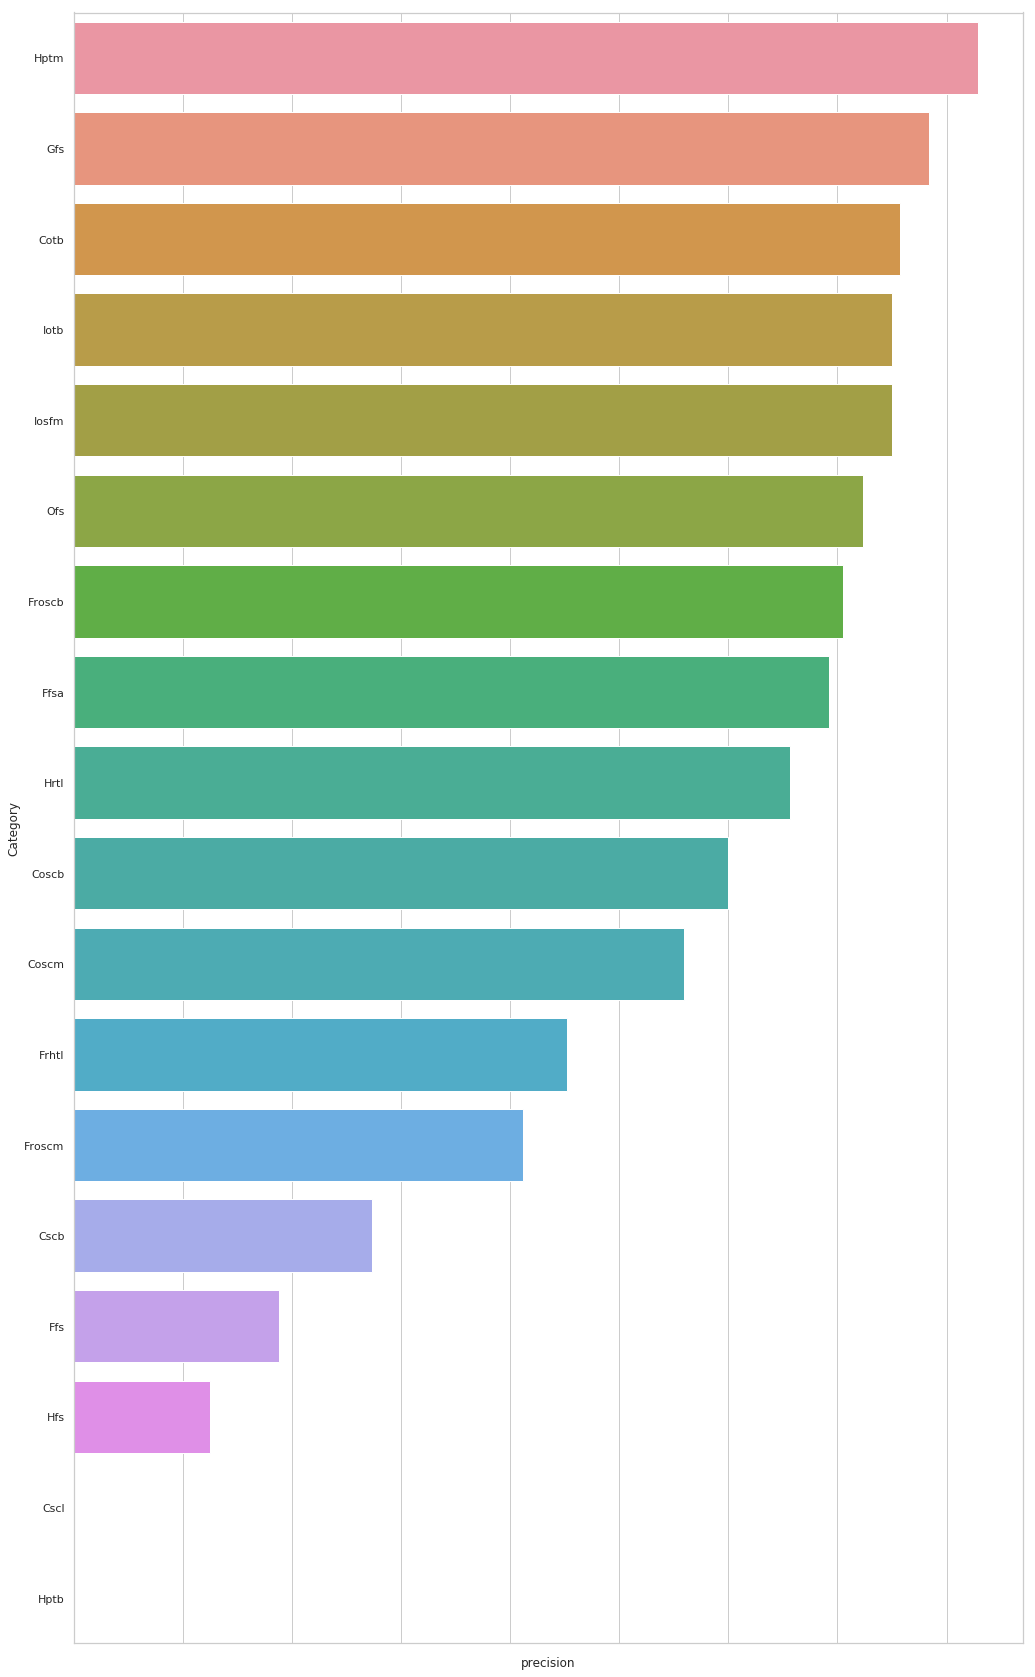

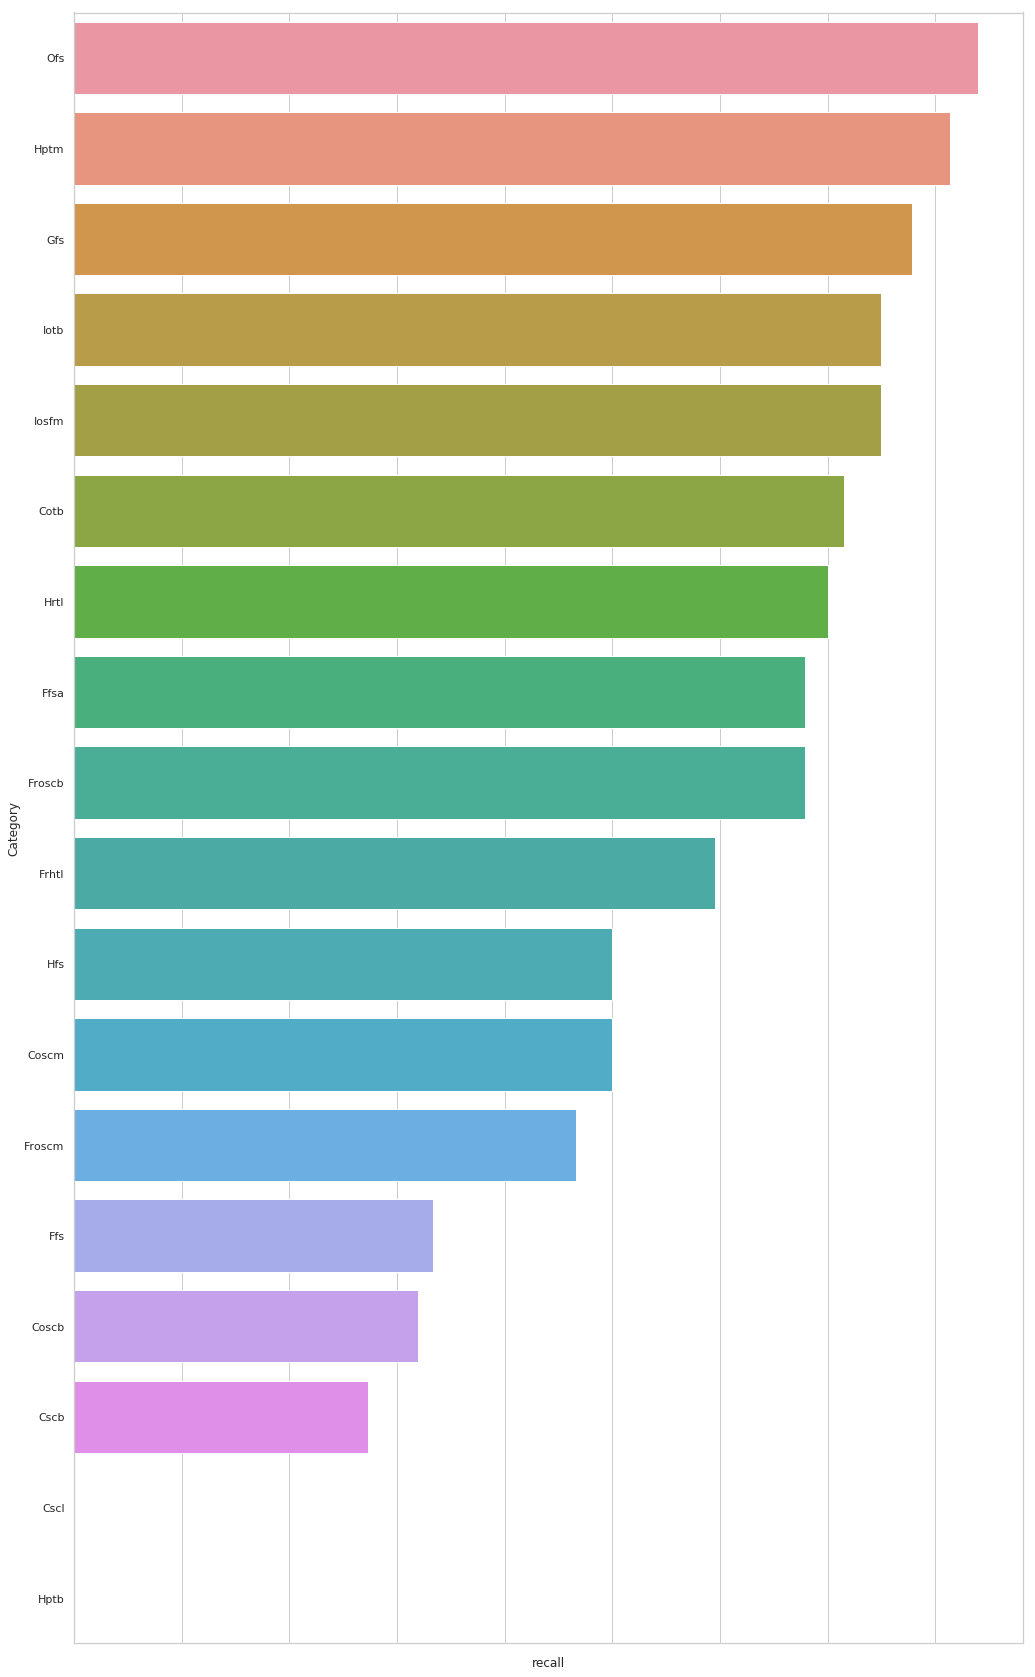

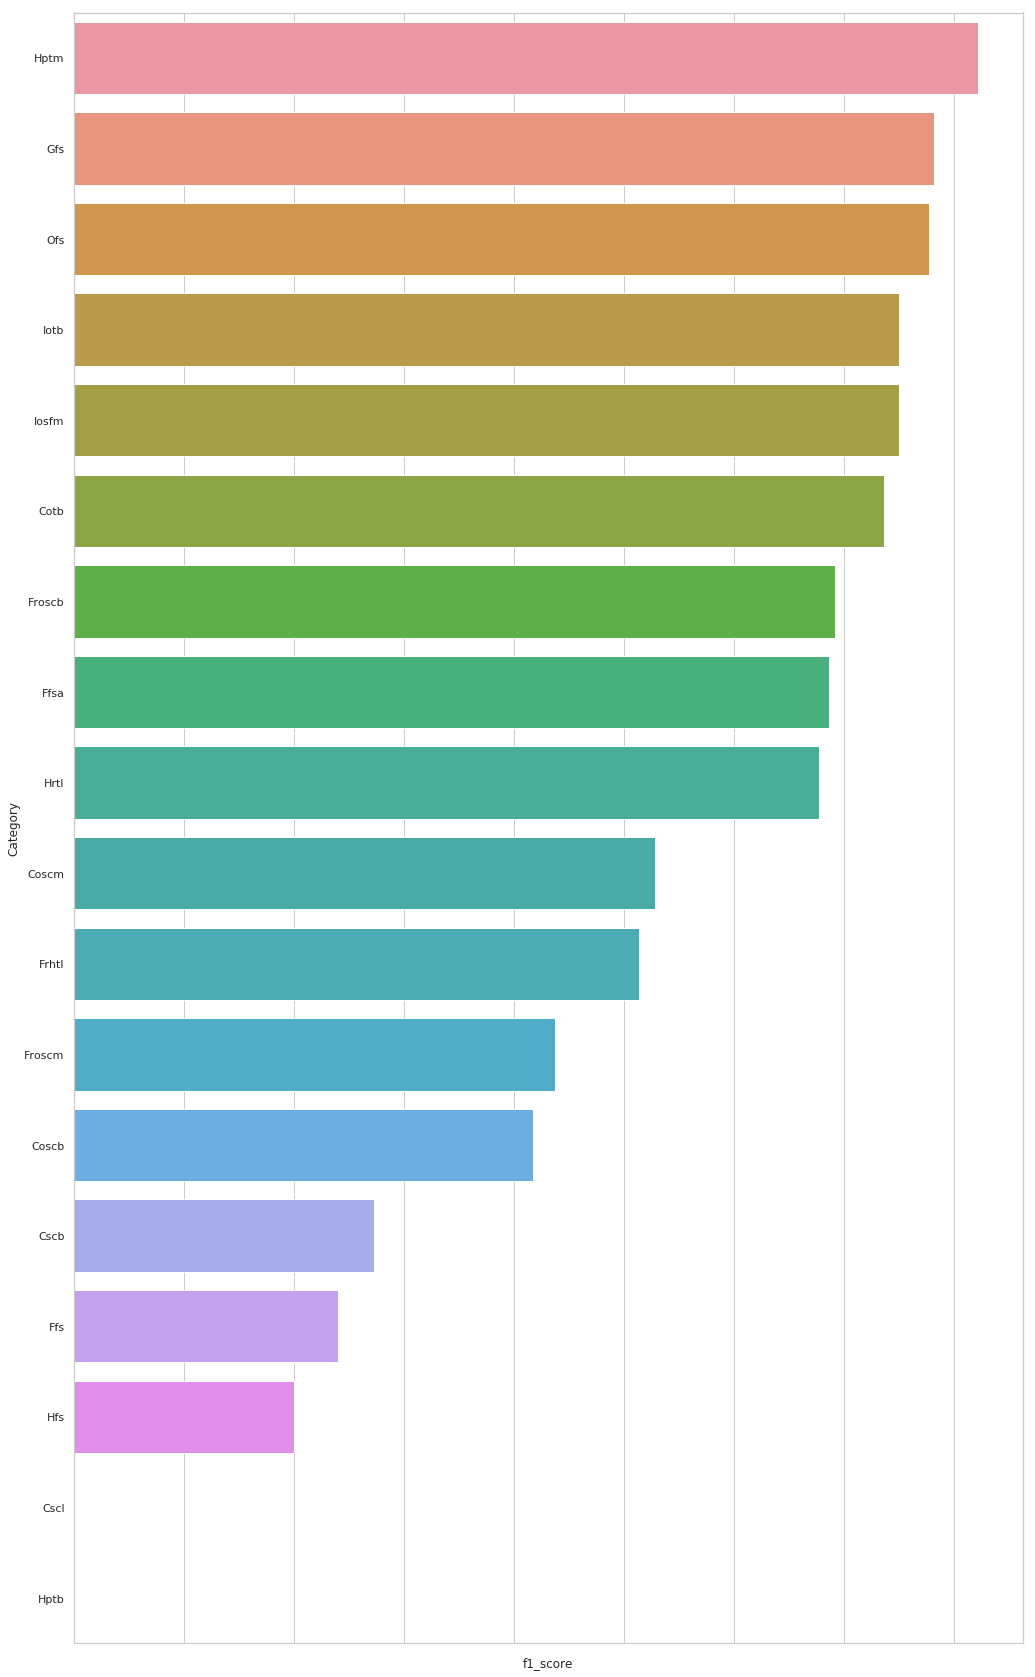

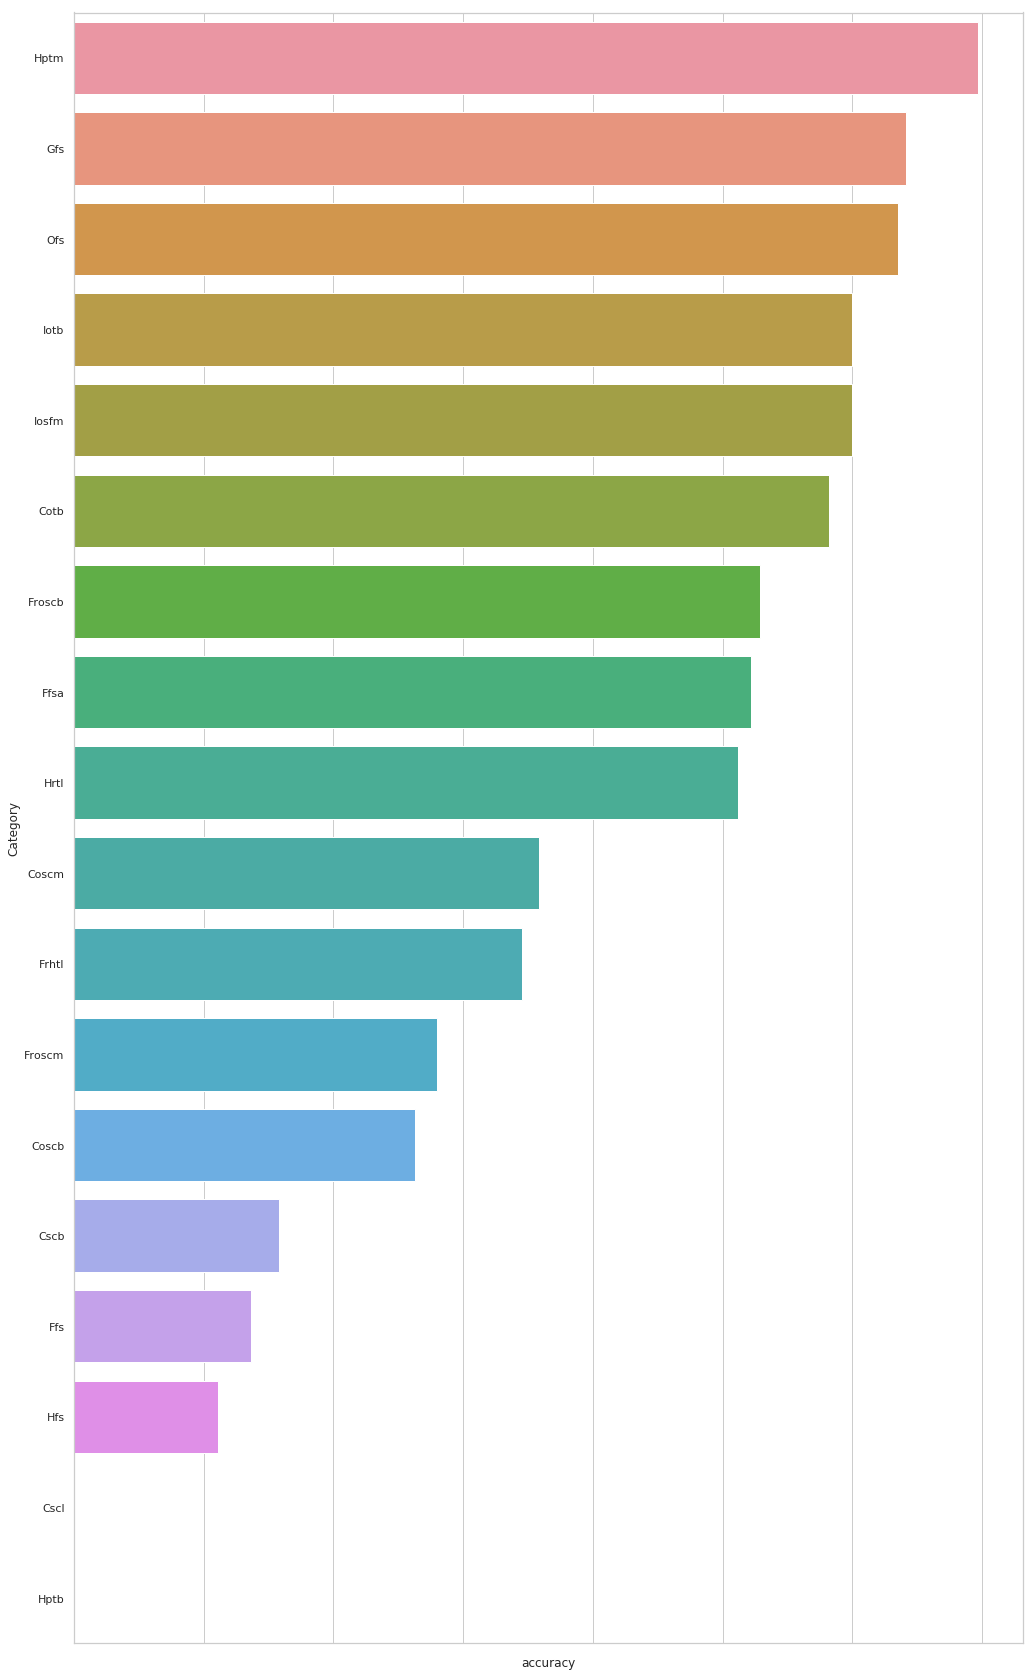

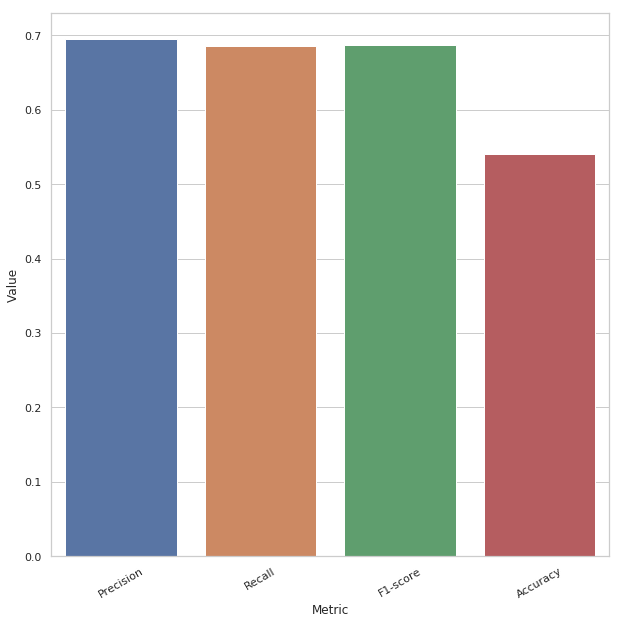

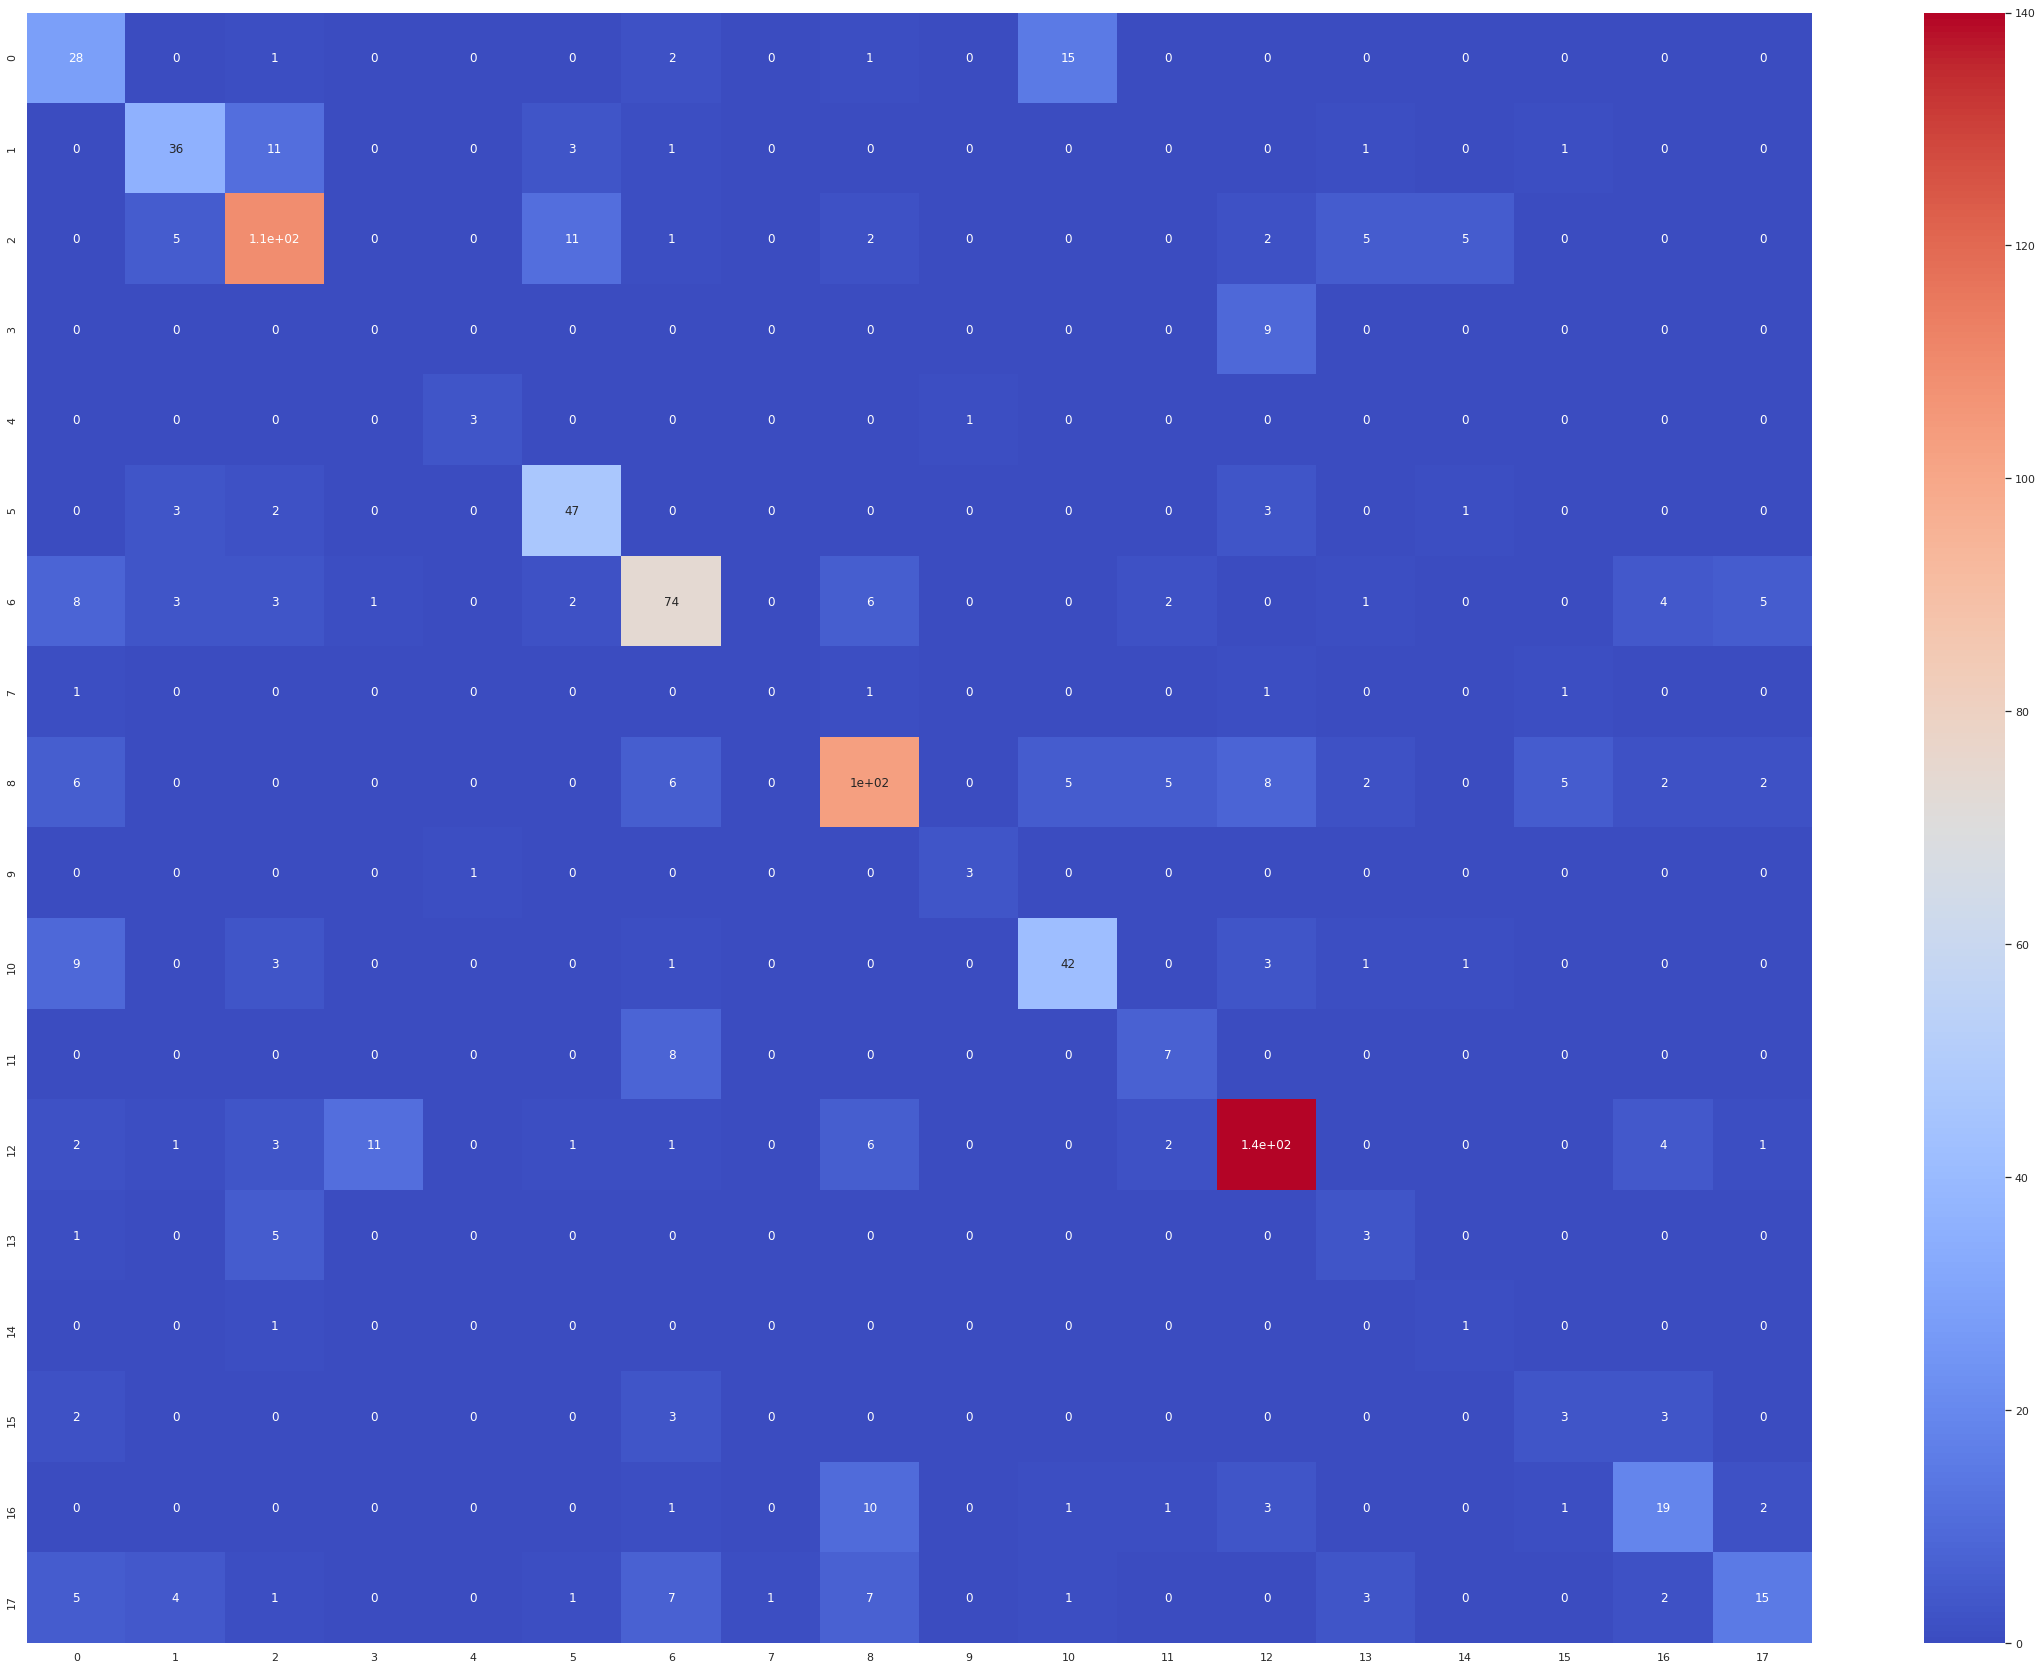

In [15]:
dataset_pred = ImagePredictionDataset.from_csv(source_path=classif_on_crops_dataset_path,
                                              images_dir=crops_images_path)
dataset_true = ImageDataset.from_csv(source_path=crops_dataset_path,
                                     images_dir=crops_images_path)
metrics = Evaluator.eval(dataset_true=dataset_true,
                         dataset_pred=dataset_pred,
                         eval_config={
                            "metrics_set": {
                                Metrics.Sets.MULTICLASS: {
                                    "average": eval_type
                                }
                            },
                            "dataset_partition": Partitions.TEST
                         })
metrics.store_eval_metrics(results_eval_path)
metrics.result_plots()

2020-10-16 12:04:24,784 [conabio_ml.datasets.dataset] [INFO ]  Creating dataset from CSV file: /shared_volume/files/crops_dataset.csv
2020-10-16 12:04:24,841 [conabio_ml.datasets.dataset] [DEBUG]  Columns in dataset: Index(['item', 'label', 'id', 'image_id', 'location', 'partition'], dtype='object')
2020-10-16 12:04:24,955 [conabio_ml.datasets.dataset] [DEBUG]  Creating dataset with 10415 registers
2020-10-16 12:04:24,962 [conabio_ml.datasets.dataset] [DEBUG]  Dataset with ordinal labels
2020-10-16 12:04:24,964 [conabio_ml.datasets.dataset] [DEBUG]  28 categories in dataset
2020-10-16 12:04:24,965 [conabio_ml.datasets.dataset] [INFO ]  Assigning labelmap with [{0: 'COSCB'}, {1: 'COSCM'}, {2: 'COTB'}, {3: 'CSCB'}, {4: 'CSCL'}, {5: 'CSFB'}, {6: 'CSFM'}, {7: 'CTB'}, {8: 'CTL'}, {9: 'FFS'}]...
2020-10-16 12:04:24,966 [conabio_ml.datasets.dataset] [DEBUG]  Splitting dataset by column 'partition'
2020-10-16 12:04:25,035 [conabio_ml.datasets.dataset] [INFO ]  Creating dataset from CSV file: /

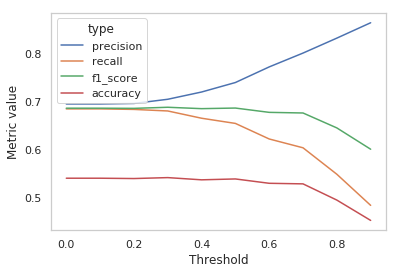

In [20]:
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from conabio_ml.datasets.images.datasets import ConabioImageDataset, ImagePredictionDataset, Partitions
from conabio_ml.evaluator.images.evaluator import ImageClassificationEvaluator, ImageClassificationMetrics

crops_ds = ConabioImageDataset.from_csv(source_path=crops_dataset_path,
                                         images_dir=crops_images_path)
classifs_ds = ImagePredictionDataset.from_csv(source_path=classif_on_crops_dataset_path,
                                              images_dir=crops_images_path)

eval_type = "MULTICLASS"
average_type = 'weighted'
zero_division = 0.

classifs_df = classifs_ds.as_dataframe(only_highest_score=True, sort_by="item")
labels = list(set(crops_ds.get_rows(Partitions.TEST)["label"]).union(set(classifs_df["label"])))

if eval_type == "MULTILABEL":
    dataset_true = crops_ds.create_multilabel_classification_dataset_from_crops(
        images_dir="",
        extension_to_append="JPG",
        inherit_partitions=True,
        inherit_fields=["location"])
else:
    dataset_true = crops_ds

results_dict = defaultdict(list)
for thres in range(0, 100, 10):
    if eval_type == "MULTILABEL":
        dataset_pred = classifs_ds.create_multiclass_dataset_from_classifs_on_crops(thres/100)
        eval_func = Evaluator.eval
    else:
        df_pred = classifs_ds.as_dataframe(only_highest_score=True, sort_by="item")
        df_pred.loc[df_pred["score"] < thres/100, "label"] = "empty"
        classifs_ds.data = df_pred
        dataset_pred = classifs_ds
        eval_func = ImageClassificationEvaluator.eval

    if len(dataset_pred.data.loc[dataset_pred.data["label"] == "empty"]) > 0:
        _labels = labels + ["empty"]
    else:
        _labels = labels
    
    metrics = eval_func(dataset_true=dataset_true,
                        dataset_pred=dataset_pred,
                        eval_config={
                            'metrics_set': {
                                eval_type: {
                                    "average": average_type,
                                    "zero_division": zero_division
                                }
                            },
                            'dataset_partition': Partitions.TEST,
                            "labels": _labels
                        })
    _metrics = ["precision", "recall", "f1_score"]
    if eval_type == "MULTICLASS":
        _metrics.append("accuracy")
    for metric in _metrics:
        results_dict["threshold"].append(thres/100)
        results_dict["value"].append(metrics.results[eval_type]["one_class"][metric])
        results_dict["type"].append(metric)
df = pd.DataFrame(results_dict)
ax = sns.lineplot(data=df, x="threshold", y="value", hue="type")
ax.set(xlabel='Threshold', ylabel='Metric value')
ax.grid()
plt.show()